# TMA 4320 Project 3

## Kandidatnr: 10123, 10160, 10088

This report explores four different numerical ordinary differential equation methods regarding a specific dynamic system from classical physics. These methods are the Shampine-Bogacki method, the RK4 method, Kahans method for quadratic term differential equations and the Störmer-Verlet method for systems described as $q'' = f(q)$. The specific system to be studied is the Heine-Heiles model. This is a model describing planetary motion over a long time inside a galaxy of cylindrical symmetry in two dimentions. The exploration focused on three attributes of the numerical methods: The degree of convergence, the degree of energy conservation and calculations and plotting of poincare cuts. Lastly the methods will be compared and the matter of which method is more efficient and appropriate will be discussed.

### Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
!pip install numba
from numba import jit
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

# Remove annoying deprecation warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# Increase default font size
plt.rcParams.update({'font.size': 14})

### Functions

All methods except for Kahan's method are relatively straight forward to implement. This however, we do need to derive from the formula given. From section 2.3 form the sheet we got the general formula for the implicit method, with $\frac{y_{i, n+1}-y_{i, n}}{h}=\sum_{j, k=1}^{m} a_{i j k} \frac{y_{j, n} y_{k, n+1}+y_{j, n+1} y_{k, n}}{2}+\sum_{j=1}^{m} b_{i j} \frac{y_{j, n}+y_{j, n+1}}{2}+c_{i}$. 

From the Henos-Heiles model 
$\begin{aligned}
q_{1}^{\prime} &=p_{1} \\
q_{2}^{\prime} &=p_{2} \\
p_{1}^{\prime} &=-q_{1}\left(1+2 q_{2}\right) \\
p_{2}^{\prime} &=-\left(q_{2}+q_{1}^{2}-q_{2}^{2}\right)
\end{aligned}$

We set $y_{i,n+1} = x_i$ and $y_{i,n}$ = y_i to easy writing. We then get:

$\begin{aligned}
\frac{x_1-y_1}{h} &=\frac{y_3 + x_3}{2} \implies x_1/h +x_3/2 = y_1/h + y_3/2\\ 
\frac{x_2-y_2}{h} &=\frac{y_4 + x_4}{2} \implies x_2/h +x_4/2 = y_2/h + y_4/2\\
\frac{x_3-y_3}{h} &= -2\frac{y_1x_2 + y_2x_1}{2} - \frac{y_1+x_1}{2} \implies h(y_2+0.5)x_1 + hy_1x_1 +x_3 = y_3-hy_1/2\\
\frac{x_4-y_4}{h} &=-2\frac{y_1x_1 + y_2x_2}{2} - \frac{y_2+x_2}{2} \implies hy_1x_1 + h(0.5-y2)x_2 +x_4 = y_4-hy_2/2\\
\end{aligned}$

We then write this as a system of equations in the form $Ax = b$ as done in the function below.

In [ ]:
@jit(nopython=True)
def RHS(t,x): #Henos-Heiles
    return np.array([x[2],x[3],-x[0]*(1+2*x[1]),-1*(x[1]+x[0]**2-x[1]**2)]) #this is the right hand side of the equation written in one line for efficiency 

@jit(nopython=True)
def Shampine_Bogacki(IC,RHS,timestep,Time_end):
    T = Time_end
    h = timestep
    ts = np.arange(0,T,h)
    N = len(ts)
    ys = np.zeros((N+1,len(IC)))
    ys[0] = IC
    for i in range(0,N):
        if ts[i]+h > Time_end: #The last step is taken so we end up at exaclty T_end, the size of this step will be between 0 and the normal stepsize h.
            h = Time_end-ts[i]
        F1 = RHS(0,ys[i])
        F2 = RHS(0,ys[i]+0.5*h*F1)
        F3 = RHS(0,ys[i] +3*h/4*F2)
        ys[i+1] = ys[i] + h*(2*F1+3*F2+4*F3)/9
    ts = np.append(ts,Time_end)
    return ys,ts

@jit(nopython=True)
def RK4(IC,RHS,timestep,Time_end):
    T = Time_end
    h = timestep
    ts = np.arange(0,T,h)
    N = len(ts)
    ys = np.zeros((N+1,len(IC)))
    ys[0] = IC
    for i in range(0,N):
        if ts[i]+h > Time_end:
            h = Time_end-ts[i]
        F1 = RHS(0,ys[i])
        F2 = RHS(0,ys[i]+0.5*h*F1)
        F3 = RHS(0,ys[i] +0.5*h*F2)
        F4 = RHS(0,ys[i] +h*F3)
        ys[i+1] = ys[i] + h*(F1+2*F2+2*F3+F4)/6
    ts = np.append(ts,Time_end)
    return ys,ts

@jit(nopython=True)
def Kahans_method(IC,timestep,Time_end):
    T = Time_end
    h = timestep
    ts = np.arange(0,T,h)
    N = len(ts)
    ys = np.zeros((N+1,len(IC)))
    ys[0] = IC
    for i in range(0,N):
        if ts[i]+h > Time_end:
            h = Time_end-ts[i]
        y1,y2,y3,y4 = ys[i][0],ys[i][1],ys[i][2],ys[i][3]
        A = np.array(
            [[1,0,           -0.5*h,0], #matrix equation resulting from algebraic manipulation from the Henos-Heiles model
             [0,1,           0,0.5*-h],
             [h*(y2+0.5)  ,  h*y1,1,0],
             [h*y1  ,  h*(0.5-y2),0,1]])
        b = np.array([y1+h*y3/2,
                      y2+h*y4/2,
                      y3-h*y1/2,
                      y4-h*y2/2])
        ys[i+1] = np.linalg.solve(A,b)
    ts = np.append(ts,Time_end)
    return ys,ts

@jit(nopython=True)
def f(x):
    #Henos-Heiles written in the form needed in the Störmer_Verlet method. 
    return np.array([-x[0]*(1+2*x[1]),-1*(x[1]+x[0]**2-x[1]**2)])

@jit(nopython=True)
def Stormer_Verlet(IC,f,timestep,Time_end):
    T = Time_end
    h = timestep
    ts = np.arange(0,T,h)
    N = len(ts)
    ys = np.zeros((N+1,len(IC)))
    ys[0] = IC
    for i in range(0,N):
        if ts[i]+h > Time_end:
            h = Time_end-ts[i]
        p_halfstep = ys[i,2:] + 0.5*h*f(ys[i,:2])
        ys[i+1,:2] = ys[i,0:2] + h*p_halfstep
        ys[i+1,2:] = p_halfstep + 0.5*h*f(ys[i+1,0:2])
    ts = np.append(ts,Time_end)
    return ys,ts


"""Solves the problem with the adaptive steps RK45 method with strict errorbounds for "exact solution" referance in testing for convergence-order"""
def RK45_method(RHS, IC, T, dt):
    t_array = np.arange(0,T,dt) 
    t_span = (0,T)
    sol = solve_ivp(RHS,t_span,IC,method = 'RK45',atol =1e-12,rtol = 1e-12) #y som returneres er en array et objekt som må
    y = sol.y[:,:]# brukes metoder på for å få ut størrelser vi vil ha. .y gir arrey med løsninger for x1,x2,x3,x4
    y = np.transpose(y)
    t = sol.t#.t returnerer tidspunkter som korresponderer med løsningene fra .y
    return y,t

"""Find energy using the Hamiltonian given under section 5. Return array of energies throughout the simulation"""
@jit(nopython=True)
def Energy(x):
    # q1,q2,p1,p2 = x[:,0],x[:,1],x[:,2],x[:,3]
    return 0.5*(x[:,2]**2+x[:,3]**2)+0.5*(x[:,0]**2+x[:,1]**2)+x[:,0]**2*x[:,1]-(1/3)*x[:,1]**3

"""Same as the above, only returning a single energy for one instant"""
def Energy_instant(x):
    # q1,q2,p1,p2 = x[0],x[1],x[2],x[3]
    return 0.5*(x[2]**2+x[3]**2)+0.5*(x[0]**2+x[1]**2)+x[0]**2*x[1]-(1/3)*x[1]**3

"""Find initial value for p_1 given a specific energy H"""
def p_1(H):
    q_2 = 0.45
    return (2*(H-(1/6)*q_2*q_2*(3-2*q_2)))**0.5

"""Run through array and return every index where q_1 changes sign whilst p_1>0"""
@jit(nopython=True)
def crossing_points(x):
    crossing_point = np.empty(1)
    for i in range(len(x[:,0])):
        if x[i,2]>0:
            if (x[i,0]>0 and x[i+1,0]<0) or (x[i,0]<0 and x[i+1,0]>0):
                crossing_point = np.append(crossing_point, i)
    crossing_point = np.delete(crossing_point, 0) #Delete the first element used to initialize array
    return(crossing_point)

"""Call crossing_points and find values for q_2 and p_2 at each crossing point"""
def poincare_points(x):
    crossing_point = crossing_points(x)
    crossing_point = crossing_point.astype(int)

    q_2p_2 = np.zeros((len(crossing_point), 2))
    i = 0
    for j in crossing_point:
        f = interp1d([x[j,0],x[j+1,0]],[x[j,1],x[j+1,1]])
        g = interp1d([x[j,0],x[j+1,0]],[x[j,3],x[j+1,3]])
        q_2p_2[i,0] = f(0)
        q_2p_2[i,1] = g(0)
        i += 1
    return q_2p_2

### Parameters

In our study of the Henos-Heiles we will use the initial conditions where $H(q,p) = \frac{1}{12}$, timestep $h = 0.1$ and time $t \in [0, 1\, 000\,000]$ if nothing else is specified.

In [ ]:
p1_H12 = p_1(1/12)
p1_H10 = p_1(1/10)
p1_H8 = p_1(1/8)
IC = np.array([0,0.45,p1_H12,0])
timestep = 0.1
Time = 1e6

## Problem 1: Order of convergence

One of the most important attributes of an numerical integrator scheme for solving differential equations is having control over the error bounds that follows solving numericaly. Since this depends on the size of each step in the method, the way in which the global error bound depends on this, quantity is of interest. These methods are, however, well studied and this relation is already found for all methods. We did in this problem do our own test of convergence to see if our results compare well to the given orders. The order given for the numerical methods are: 

| Method   |  Order|
|----------|:-------------:|
| Shampine-Bogacki | 3 |
| RK4 |   4 |
| Kahan's method |    2 |
| Störmer-Verlet|    2 |

To do this test of convergence we first of all need an exact or near exact solution to be used as reference. Because the Heine-Borel modell does not have an analytical solution that we know of at the time writing, we will find a near exact one. This is done with the adaptive step-size method RK45 with a tolerance of $10^{-12}$ over a shorter time span of $t \in [0,T_{end}] = [0,10]s$. We do this with the function  RK45method, which uses the fairly optimised solve_ivp function from the scipy.integrate library. To compare methods we are only interested in the solution after all steps have been taken, i.e the solution at Time_end.

In [ ]:
Time_convergence_test = 10
yref,tref = RK45_method(RHS,IC,Time_convergence_test,timestep)
yref = yref[-1] #extracting the solution at time=Time_dummy

Relations betwen global errors of numerical ODE-solvers, $E$,  and stepsizes, $h$, are on the form $E(h) = Ch^p$, with $p$ being the order of convergence for the numerical method. Taking the natural logarithm of both sides, we get $\ln(E(h)) = p \ln(Ch))$. The reason we want to write the relation this way is that if we plot this function in a loglog plot, a plot where both axis are logarithmically scaled, the relation will be linear with slope $p$. This therefore makes a nice tool for comparing order of convergence from our test with the supposed "correct" one. 
To get evenly spaced points for plotting with axis logarithmically scaled we use stepsizes evenly spaced over an log scale. This is automatically done for us with the logspace function from the numpy library. We then solve the system for all h-sizes in this list for all numerical methods. 

In [ ]:
hs = np.logspace(0,-4,20)

RK45s = np.array([yref for h in hs])
Shampine_Bogackis = np.zeros((len(hs),4))
RK4s= np.copy(Shampine_Bogackis)
Kahans_methods = np.copy(Shampine_Bogackis)
Stormer_Verlets = np.copy(Shampine_Bogackis)

for count,h in enumerate(hs):
    y, t = Shampine_Bogacki(IC,RHS,h,Time_convergence_test)
    Shampine_Bogackis[count] = y[-1]
    y, t = RK4(IC,RHS,h,Time_convergence_test)
    RK4s[count] = y[-1]
    y, t, = Kahans_method(IC,h,Time_convergence_test)
    Kahans_methods[count] =  y[-1]
    y, t = Stormer_Verlet(IC,f,h,Time_convergence_test)
    Stormer_Verlets[count] = y[-1]

To calculate global error we use the 2-norm of the difference between the solutions from the four methods with the referance-solutions found with RK45, given $||y_{sol,i}-y_{ref}||_2$. This is done as the default norm with the norm function from the numpy.linalg library. We then plot the global errors values, $(h_i,E(h_i)$ in the loglog plot together with the "line" $10^p$ with $p$ equalizing the supposed order of the the given method.

In [ ]:
ys1error = np.array([np.linalg.norm(Shampine_Bogackis[i]-RK45s[i]) for i in range(len(hs))])
ys2error = np.array([np.linalg.norm(RK4s[i]-RK45s[i]) for i in range(len(hs))])
ys3error = np.array([np.linalg.norm(Kahans_methods[i]-RK45s[i]) for i in range(len(hs))])
ys4error = np.array([np.linalg.norm(Stormer_Verlets[i]-RK45s[i]) for i in range(len(hs))])

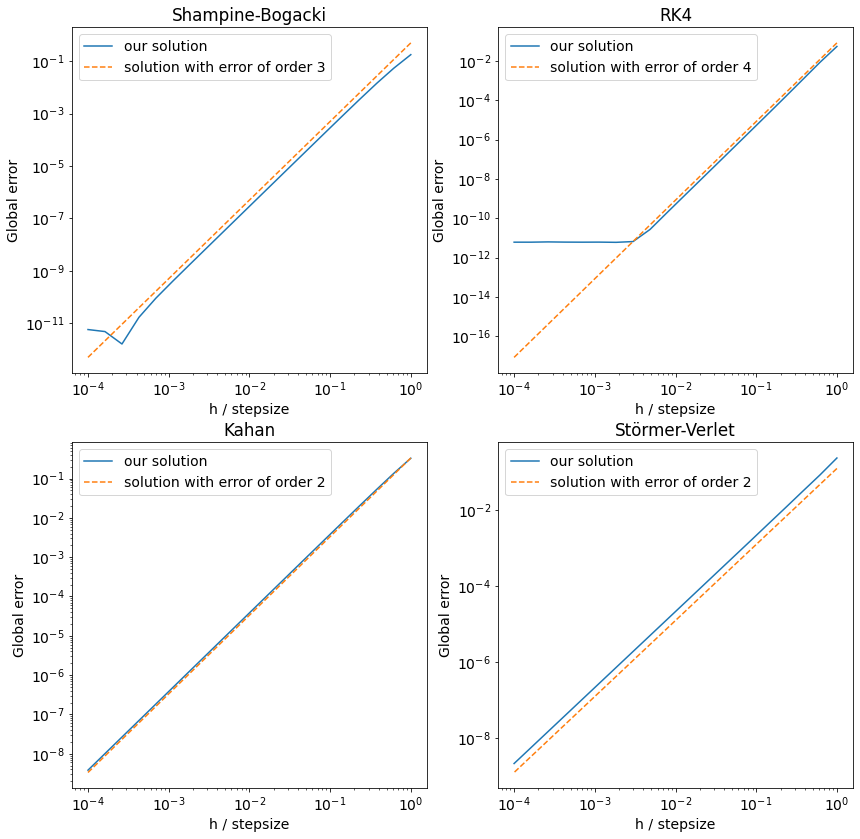

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (14,14))

ax[0,0].title.set_text("Shampine-Bogacki")
ax[0,0].set_xlabel("h / stepsize")
ax[0,0].set_ylabel("Global error")
ax[0,0].loglog(hs,ys1error, label = "our solution")
ax[0,0].loglog(hs,hs**3/2,"--", label = "solution with error of order 3")
ax[0,0].legend()

ax[0,1].title.set_text("RK4")
ax[0,1].set_xlabel("h / stepsize")
ax[0,1].set_ylabel("Global error")
ax[0,1].loglog(hs,ys2error, label = "our solution")
ax[0,1].loglog(hs,hs**4/12,"--", label = "solution with error of order 4")
ax[0,1].legend()

ax[1,0].title.set_text("Kahan")
ax[1,0].set_xlabel("h / stepsize")
ax[1,0].set_ylabel("Global error")
ax[1,0].loglog(hs,ys3error, label = "our solution")
ax[1,0].loglog(hs,hs**2/3,"--", label = "solution with error of order 2")
ax[1,0].legend()

ax[1,1].title.set_text("Störmer-Verlet")
ax[1,1].set_xlabel("h / stepsize")
ax[1,1].set_ylabel("Global error")
ax[1,1].loglog(hs,ys4error, label = "our solution")
ax[1,1].loglog(hs,hs**2/8,"--", label = "solution with error of order 2")
ax[1,1].legend()


To get some numerical values to work with we can use the formula: $$ p \approx \frac{\ln\frac{E(h_2)}{E(h_1)}}{\ln\frac{h_2}{h_1}}$$. The chosen stepsizes $h_1$ and $h_2$ must here only in theory be different. Since small sizes introduce rounding errors and big stepsizes riskning asymtotacly different behaviour, they should, however, be chosen somewhere with good behaviour. From the plot it seems like somewhere in the middle of our logspaced interval have a straight line, so we choose the concecutive stepsizes indexed at 10 and 9 from our logspaced list of different stepsizes and their corresponding solutions to solve for their slope.

In [ ]:
p1 = np.log(ys1error[10]/ys1error[9])/np.log(hs[10]/hs[9]) 
p2 = np.log(ys2error[10]/ys2error[9])/np.log(hs[10]/hs[9])
p3 = np.log(ys3error[10]/ys3error[9])/np.log(hs[10]/hs[9])
p4 = np.log(ys4error[10]/ys4error[9])/np.log(hs[10]/hs[9])
ps = [p1,p2,p3,p4]
print(f"The numericaly calculated orders of convergence are up to two decimals are: ")
for p in ps:
    print(f"{p:.2f} for stepsizes {hs[10]:.4f} and {hs[9]:.4f}")


The numericaly calculated orders of convergence are up to two decimals are: 
3.00 for stepsizes 0.0078 and 0.0127
4.01 for stepsizes 0.0078 and 0.0127
2.00 for stepsizes 0.0078 and 0.0127
2.00 for stepsizes 0.0078 and 0.0127


The results rounded to two decimals are $$3.00, 4.01, 2.00, 2.00$$ for Shampine-Bogacki, RK4, Kahan's method and Störmer-Verlet respectively calculated with the stepsizes $h_1 = 0.0127 $ and $ h_2 = 0.0078$. This  equals the order given with the numerical methods in the sheets exactly for all but for the RK4 method, which is just $0.01$ off. 

**Discussion of results**

For stepsizes $h \gt 10^{-2.5}$, the lines corresponding to the global error calculated and the lines of expected error are looking fairly parallel for all methods. For $h \gt 10^{-3.5}$ only RK4 fails to give the correct slope given its supposed order in referance to RK45 with tolerances $10^{-12}$. Meanwhile Kahan's method and Störmer-Verlet corresponds to advocated at all tested values for $h$. The reason being RK4 is easily explained by the fact that the global error in our case is in referance to the solution of RK45. Due to the fact that we have chosen the tolerances $10^{-12}$ in the adaptive RK45 method, this obviously doesn't work as a referance when the error in the RK4 method becomes even lass than that because of the small stepsize.

## Problem 2: Conservation of energy

In physics, and particularly in Hamiltonian mechanics where the formula for the energy of the system directly determines the differential equation of the system, the degree of which an numerical error changes the total energy of the system can be one of the most important aspects of which numerical method to choose. This makes examinating how well our numerical methods conserve energy over longer times, one of the more important studies regarding the specific system we study. 

The Hamiltonian $H$ is the energy function, defined as the sum of the kinetic and potential energy $T+V$ via the position and momentum $\textbf{q}$ and $\textbf{p}$. For this particular problem, the Hamiltionian is $H(q_1,q_2,p_1,p_2) = \frac{1}{2}(p_1^2 + p_2^2) + \frac{1}{2}(q_1^2 + q_2^2) + (q_1^2q_2 - \frac{1}{3}q_2^3)$. This is then made into the function in the code called $\texttt{Energy(x)}$ where $\texttt{x}$ is the vector $(q_1,q_2,p_1,p_2)$. This is then plotted over the longer time interval $ t \in [0,1\,000\,000]$.

We have investigated the system using an initial condition where $H_0=\frac{1}{12}=0.08\bar{3}$. Assuming all energy is conserved, all methods should ideally give an energy exactly equal to $0.08\bar{3}$  at all times.

In [ ]:
ys1,ts1 = Shampine_Bogacki(IC,RHS,timestep,Time)
ys2,ts2 = RK4(IC,RHS,timestep,Time)
ys3,ts3 = Kahans_method(IC,timestep,Time)
ys4,ts4 = Stormer_Verlet(IC,f,timestep,Time)

In [ ]:
E1 = Energy(ys1)
E2 = Energy(ys2)
E3 = Energy(ys3)
E4 = Energy(ys4)

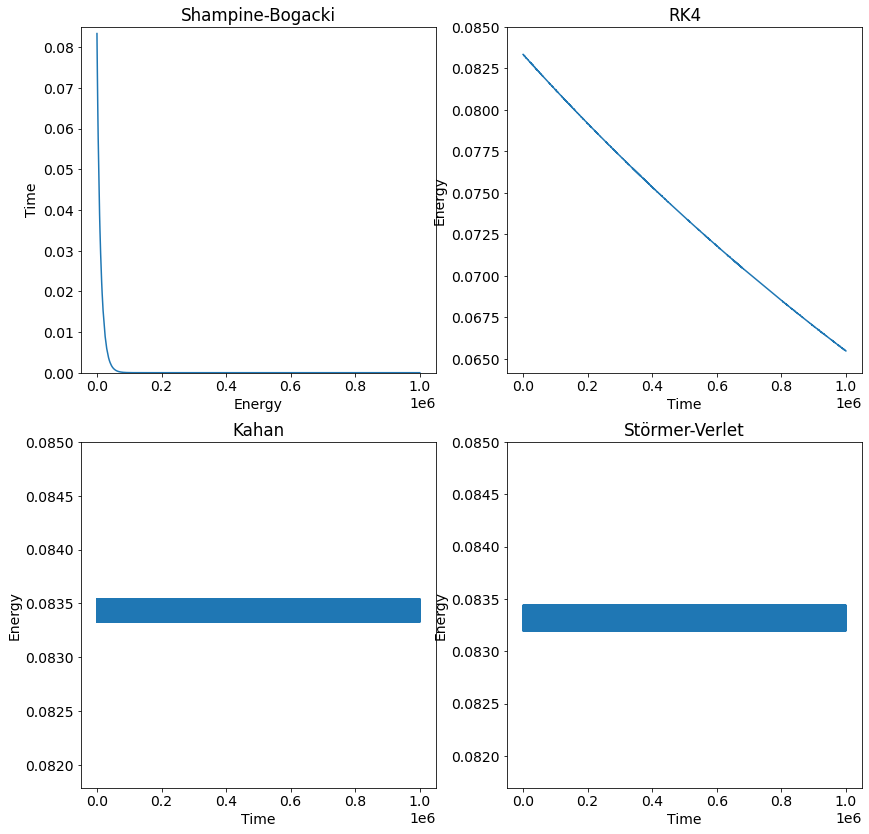

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (14,14))

ax[0,0].title.set_text("Shampine-Bogacki")
ax[0,0].set_xlabel("Energy")
ax[0,0].set_ylabel("Time")
ax[0,0].set_ylim([0.98*E1[-1], 1.02*E1[0]])
ax[0,0].plot(ts1,E1)

ax[0,1].title.set_text("RK4")
ax[0,1].set_ylabel("Energy")
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylim([0.98*E2[-1], 1.02*E2[0]])
ax[0,1].plot(ts2,E2)

ax[1,0].title.set_text("Kahan")
ax[1,0].set_ylabel("Energy")
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylim([0.98*E3[-1], 1.02*E3[0]])
ax[1,0].plot(ts3,E3)

ax[1,1].title.set_text("Störmer-Verlet")
ax[1,1].set_ylabel("Energy")
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylim([0.98*E4[-1], 1.02*E4[0]])
ax[1,1].plot(ts4,E4)

The figures above show that the Shampine-Bogacki method's energy over time quickly dips, in something that looks like a $e^{-kx}$ relation between energy and time. The RK4 method also drifts away over time, but this is much slower and in what looks like a linear relationship. Kahan's method and Störmer-Verlet however looks like having no change in energy over time. Between these graphs however, the average-energy which the system is oscillating seems to differ by only a small amount. We explore this further below.

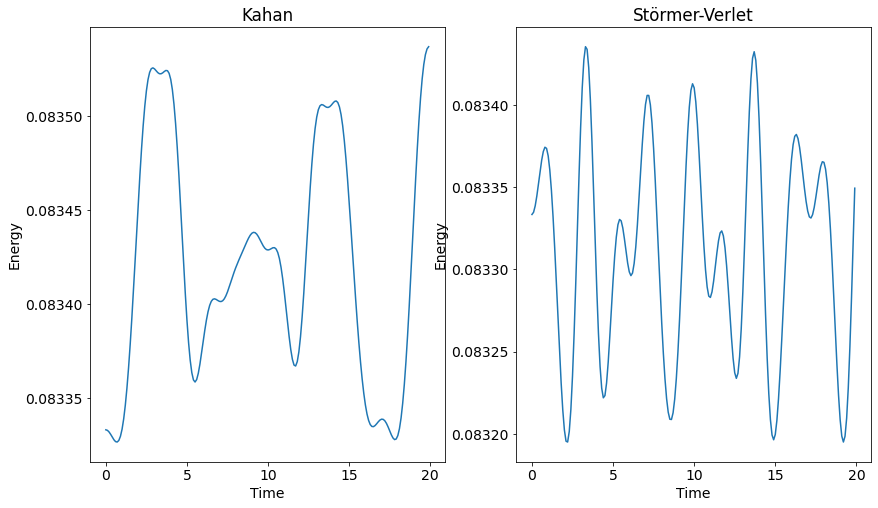

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14,8))

ax[0].title.set_text("Kahan")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Time")
ax[0].plot(ts3[:200],E3[:200])

ax[1].title.set_text("Störmer-Verlet")
ax[1].set_ylabel("Energy")
ax[1].set_xlabel("Time")
ax[1].plot(ts4[:2000],E4[:2000])

In Kahan's method we get an oscillation with amplitudes $ E \in [0.08330, 0.08355]$, with a spread of energy $\Delta E = E_{max}-E_{min} \approx 0.00025$, which gives $\langle E \rangle \approx 0.083425$.

For the Störmer-Verlet method we get $E \in [0.08320, 0.08345]$, with a spread of energy $\Delta E \approx 0.00025$, which gives $\langle E \rangle \approx 0.083325$.

The Störmer-Verlet method averages around the analytical energy $0.08\bar{3}$, whilst Kahan's method seems to  give an energy always varying above $0.08\bar{3}$, with it as its lower boundary.

This gives us an oscilation of energy with the same amplitudes for the two methods, but Kahan's method gives an energy averaging $+0.0001$ from that of Störmer-Verlet. This is again all in the case of $H(q,p) = \frac{1}{12}$.

A question that needs to be answered is why two of our numerical methods conserve energy to a so much greater extent than others? In the case of Störmer-Verlet it is because it is a symplectic method, meaning that given a small enough stepsize $h$, a finite perbubation of the solutions energy will remain invariant over an exponential $e^{\frac{h_0}{2h}}$ amount of time.[1] The hamiltonian will therefore, with all intent and purposes, given a small enough stepsize, be invariant when symplecticly integrated. Kahan's method is, however, not generally symplectic. [2] It does seem to conserve energy in the Henos-Heiles system though.

**Discussion of results**

In the four numerical methods explored, the plots that outlier is definetly the Shampine-Bogacki method. The energy is, in this case, not very well conserved over any length of time, because of the speed of descent of the $e^{-kx}$ . RK4 also have a problem with conservation of energy, but the decension is much slower than the case for Sahmpine-Bogacki. Our graphs shows a coefficient of maybe $\frac{0.02}{1000000} = 2 \times10^{-8}$,  meaning in times $T \lt T_{tol}$ for some acceptable tolerance the method should be fine. If not, both Kahas method and Störmer-Verlet both looks like they conserve energy perfectly with neither showing any signs of diverging from the starting energy. At least it seems so at $ T = 1\,000\,000s$ and stepsize $h = 0.1s$. Thus, if energy conservation is of the upmost importance, Kahan's method and Störmer-Verlet should probably be used over Shampine-Bogacki even though they converge slower.

## Problem 3:   Poincare cuts

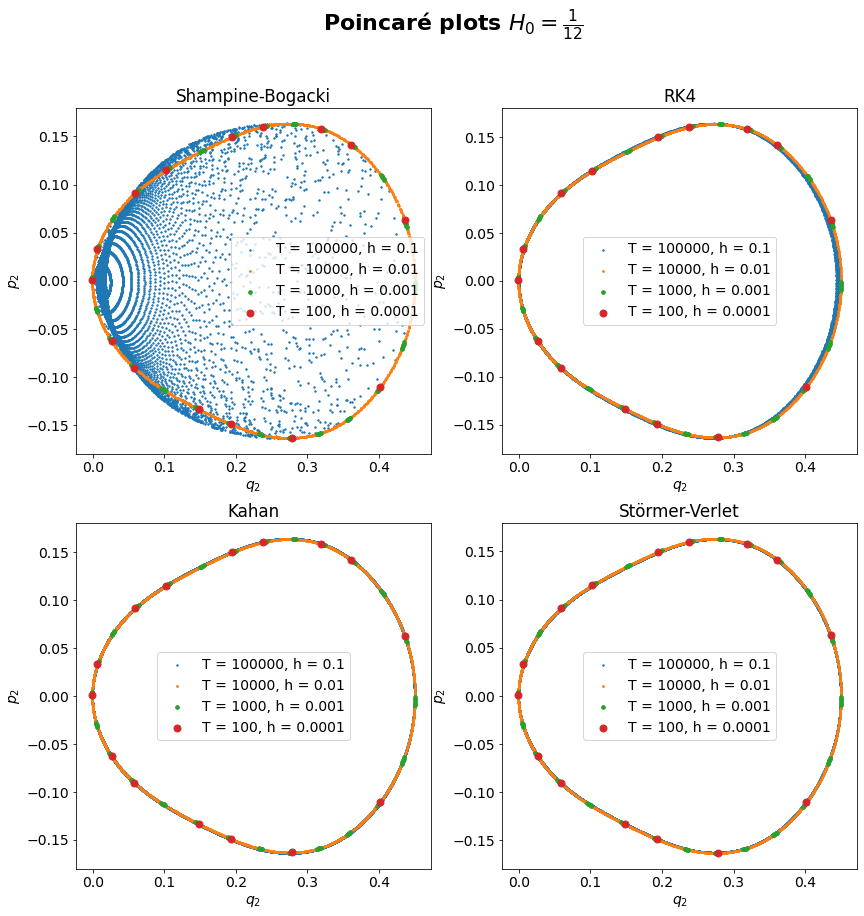

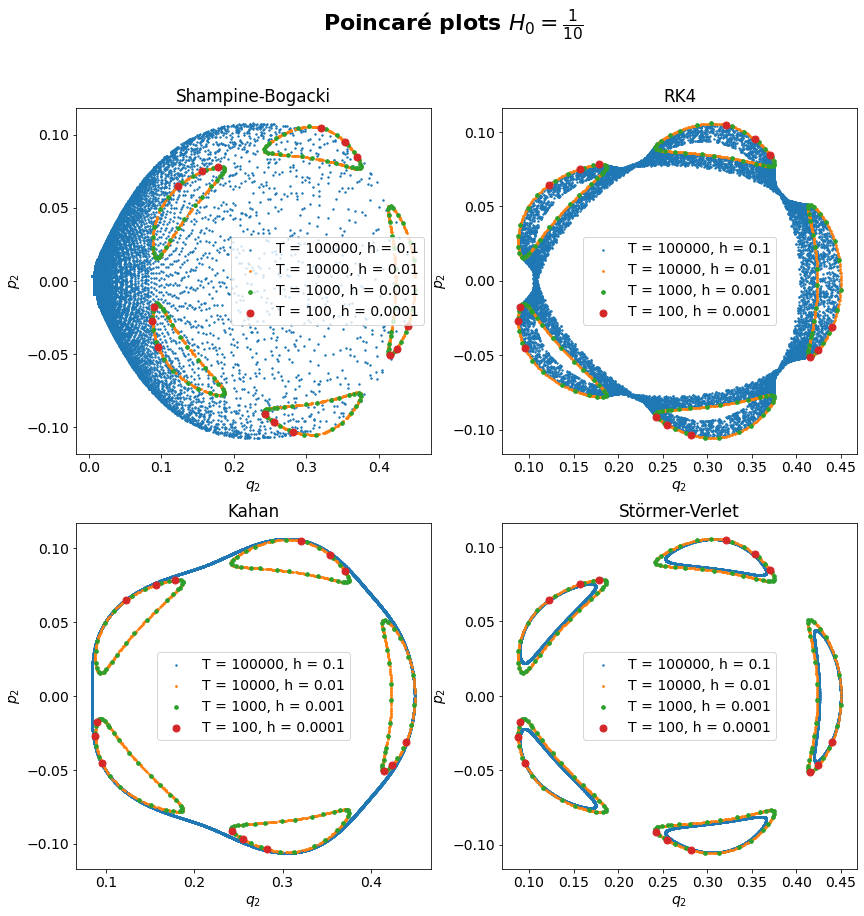

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
"""Run simulation for all four methods at four different step sizes and two different initial conditions"""
for p1 in [p1_H12, p1_H10]:
    fig, ax = plt.subplots(2,2, figsize = (14,14))

    IC = np.array([0,0.45,p1,0])
    P = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    
    for i in range(4):
        timestep = 10**(-(i+1))
        Time = int(1e7*10**(-(i+1)))

        ys1,ts1 = Shampine_Bogacki(IC,RHS,timestep,Time)
        ys2,ts2 = RK4(IC,RHS,timestep,Time)
        ys3,ts3 = Kahans_method(IC,timestep,Time)
        ys4,ts4 = Stormer_Verlet(IC,f,timestep,Time)

        P[0][i] = poincare_points(ys1)
        P[1][i] = poincare_points(ys2)
        P[2][i] = poincare_points(ys3)
        P[3][i] = poincare_points(ys4)

        ax[0,0].scatter(P[0][i][:,0],P[0][i][:,1], s=2+i**3.5, label=f"T = {Time}, h = {timestep}")
        ax[0,1].scatter(P[1][i][:,0],P[1][i][:,1], s=2+i**3.5, label=f"T = {Time}, h = {timestep}")
        ax[1,0].scatter(P[2][i][:,0],P[2][i][:,1], s=2+i**3.5, label=f"T = {Time}, h = {timestep}")
        ax[1,1].scatter(P[3][i][:,0],P[3][i][:,1], s=2+i**3.5, label=f"T = {Time}, h = {timestep}")

    if p1 == p1_H12:
        fig.suptitle(r"Poincaré plots $H_0=\frac{1}{12}$", fontsize=22, fontweight='bold')
    if p1 == p1_H10:
        fig.suptitle(r"Poincaré plots $H_0=\frac{1}{10}$", fontsize=22, fontweight='bold')
    
    ax[0,0].title.set_text("Shampine-Bogacki")
    ax[0,0].set_xlabel("$q_2$")
    ax[0,0].set_ylabel("$p_2$")
    ax[0,0].legend()

    ax[0,1].title.set_text("RK4")
    ax[0,1].set_xlabel("$q_2$")
    ax[0,1].set_ylabel("$p_2$")
    ax[0,1].legend()

    ax[1,0].title.set_text("Kahan")
    ax[1,0].set_xlabel("$q_2$")
    ax[1,0].set_ylabel("$p_2$")
    ax[1,0].legend()

    ax[1,1].title.set_text("Störmer-Verlet")
    ax[1,1].set_xlabel("$q_2$")
    ax[1,1].set_ylabel("$p_2$")
    ax[1,1].legend()

For all step sizes $h\in \{10^{-2}, 10^{-3}, 10^{-4}\}$ the results are relatively similiar, apart from maybe Shampine-Bogacki, where you can see some drift in the points when the step size is at $h=0.01$. It is first when you look at $h=0.1$ and a simulation time of $1\,000\,000$ that you can see some really interesting differences in the methods.

We see that Shampine-Bogacki converges towards $(q_2,p_2)=(0,0)$. This correlates well with what we have already seen in this method's ability to conserve energy, as energy going to zero ($H\rightarrow 0$) would imply $(q_1\rightarrow0, \;\;q_2\rightarrow 0, \;\;q_1\rightarrow0, \;\;q_2\rightarrow 0)$. Also RK4's lack of ability to conserve energy is visible in its Poincaré plot, as we see the points appear in a wider band, as the system loose energy. 

Kahan and Störmer-Verlet produce qualitatively identical and high quality Poincaré plots for $H_0=\frac{1}{12}$. It is first at $H_0=\frac{1}{10}$ we see how these two methods differ in the errors they produce. The analytic solution for Hénon–Heiles at $H_0=\frac{1}{10}$ with these particular starting conditions, should give five seperate closed lops as opposed to the one in $H_0=\frac{1}{12}$. Where as both methods perform well when it comes to energy conservation, it is obvious that Störmer-Verlet is superior to Kahan when it comes to global error. The pattern of the five distinct halfmoons is preserved and not conjoined over time.

## Conclusion

Every numerical method comes attached with some margin of error, and the error can manifest itself in different ways. Thus what errors that are accaptable and what is not, is of uttermost importance when choosing which numerical method to use. In this exploration of the methods Shampini-Bogacki, Runge-Kutta 4, Kahan and Störmer-Verlet, we have studied the deegree of convergence, the degree of energy conservation, and compared all methods using Poincare plots. From our results we have confirmed the order of convergence of the methods are in fact as given, with $$3, 4, 2, 2$$ for Shampine-Bogacki, RK4, Kahan's method and Störmer-Verlet respectively. We have found Kahan's and Störmer-Verlet to conserve energy up to time $t =1\,000\,000$ with timesteps $h = 0.1$, while Shampine-Bogacki and RK4 does not. The Poincaré section seems to be not too dependent on which method we use with initial conditions $H(q,p) = \frac{1}{12}$, as long as it is not Shampine-Bogacki with stepsize $h \gt 0.01$. For the initial condition $H(q,p) = \frac{1}{10}$, however, only the Störmer-Verlet method gives the recognizable solution shape already at stepsize $h = 0.1$. 

So which method should be used on this problem? Here we have to choose between the error of a bad convergence order versus having a energy that drifts away over time when it should not for an autonomous hamiltonian system. Over a shorter time interval, the energy when using RK4 should probably not drift too far away as argued for earlier, making it a possable contender. The safe bet would still probably be the energy conserving ones, however, even though they are only of order 2. Particularly the Störmer-Verlet seems like a good choice, needing only one functionevaluation per timestep in addition to giving the fastest converging "right" Poincare cut for $H(q,p) = \frac{1}{10}$.


**References**

[1] E. Hairer, Ch. Lubich, and G. Wanner. Geometric numerical integration, volume 31 of Springer Series in Computational Mathematics. Springer, Heidelberg,
2010. Structure-preserving algorithms for ordinary differential equations, Reprint of
the second (2006) edition.https://link.springer.com/content/pdf/10.1007%2F3-540-30666-8.pdf

[2] Elena Celledoni1 ,Robert I McLachlan ,Brynjulf Owren and G R W Quispel 2012, Geometric properties of Kahan’s method page 8
https://arxiv.org/pdf/1209.1164.pdf

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3f8cba7-482d-4450-b37c-4b69593c4ead' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>